In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle
import random
import requests
import seaborn as sns
import os

from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from typing import Any, Dict, List, Tuple, Union
from xgboost import XGBClassifier

from microservice import IUMModel
from utility import (
    load_data,
    get_buckets_indices,
    get_prediction_based_on_probabilities,
    get_most_optimal_threshold,
    get_s_p,
    get_t,
    get_xgb_logreg_f1_scores,
    is_xgb_better,
    BUCKETS_CNT,
    T_ALPHA,
    Model,
    ArrayLike
)

Wybrane cechy

In [2]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f"features/{FEATURE_VERSION}/feature.csv"

FEATURES = [
    'number_of_advertisements',
    'number_of_tracks',
    'number_of_skips',
    'number_of_likes',
    'number_of_liked_tracks_listened',
    'number_of_tracks_in_favourite_genre',
    'total_number_of_favourite_genres_listened',
    'average_popularity_in_favourite_genres',
    'total_tracks_duration_ms',
    'number_of_different_artists',
    'average_release_date',
    'average_duration_ms',
    'explicit_tracks_ratio',
    'average_popularity',
    'average_acousticness',
    'average_danceability',
    'average_energy',
    'average_instrumentalness',
    'average_liveness',
    'average_loudness',
    'average_speechiness',
    'average_tempo',
    'average_valence',
    'average_track_name_length',
    'average_daily_cost'
]

TARGETS = [
    "premium_user_numerical",
    "will_buy_premium_next_month_numerical"
]

TARGET_AND_FEATURES = TARGETS + FEATURES

In [3]:
data_frame = pd.read_csv(FEATURE_PATH)

In [4]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,...,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,...,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,...,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,...,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,...,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


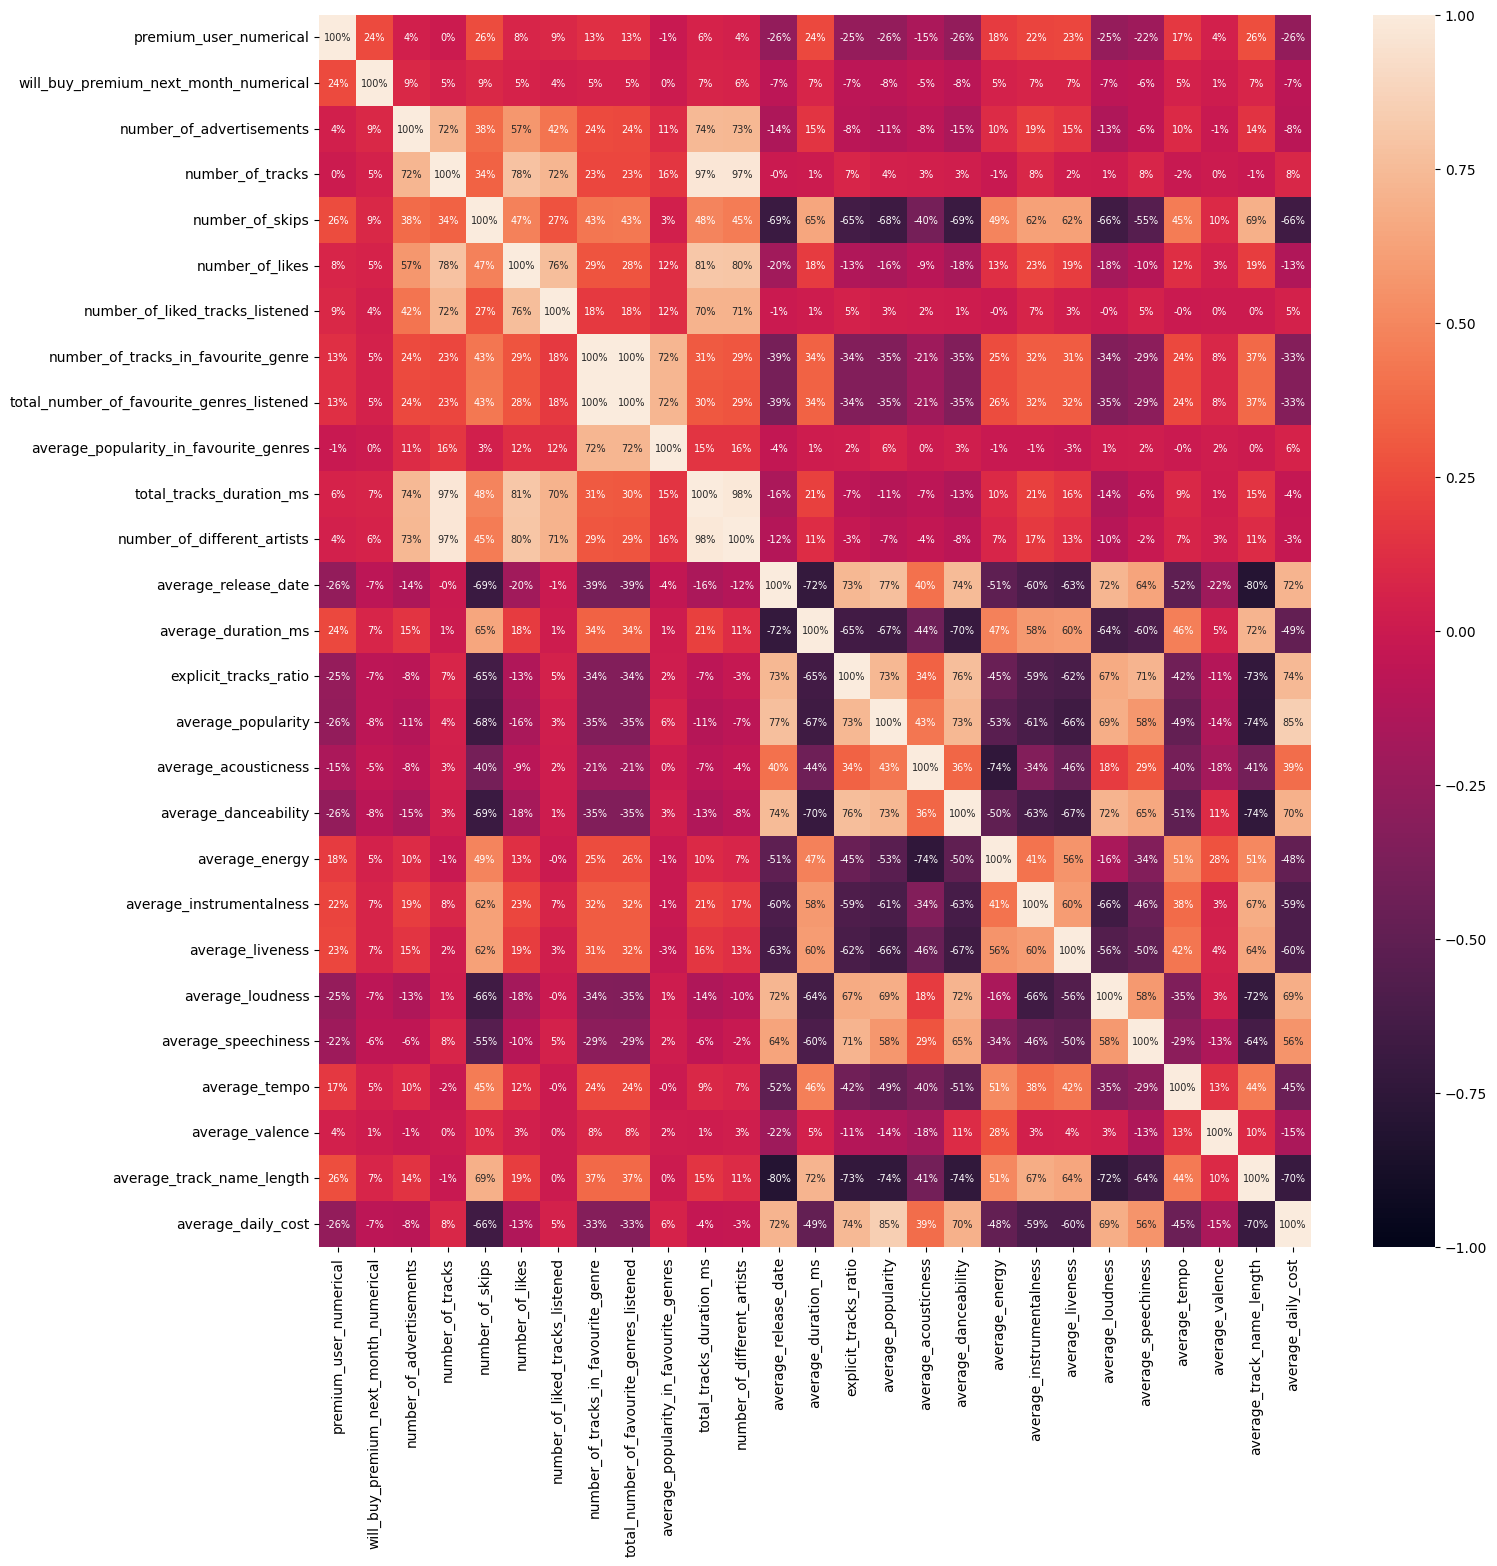

In [5]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES] \
    .corr(method='spearman')

plt.figure(figsize=(16, 16))

sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns,  # type: ignore
    yticklabels=correlation_matrix.columns,  # type: ignore
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0%",
    vmin=-1,
    vmax=1,
)

plt.show()

Definiujemy pipeline do uzupełnienia danych pustych oraz przeskalowania danych

In [6]:
pipeline = Pipeline([
    ("simple_imputer", SimpleImputer()),
    ("standard_scaler", StandardScaler())
])

Dzielimy dane na dane trenujące oraz testowe do późniejszych eksperymentów A/B

In [7]:
TRAINING_UP_TO = 2023
TRAIN_DATA: pd.DataFrame = data_frame.loc[data_frame.year < TRAINING_UP_TO, :]
TEST_DATA: pd.DataFrame = data_frame.loc[data_frame.year >= TRAINING_UP_TO, :]
TEST_SIZE = 0.33

pipeline dobieramy na podstawie samych danych testowych


In [8]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(
    TRAIN_DATA[FEATURES],
    TRAIN_DATA[TARGETS],
    test_size=TEST_SIZE
)
X_train_temp: pd.DataFrame
X_test_temp: pd.DataFrame
Y_train: pd.DataFrame
Y_test: pd.DataFrame

train_data = pipeline.fit_transform(X_train_temp)
test_data = pipeline.transform(X_test_temp)
X_train = pd.DataFrame(train_data, columns=FEATURES)
X_test = pd.DataFrame(test_data, columns=FEATURES)

In [9]:
X_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,-0.859272,-0.193497,0.655555,0.578129,0.071878,2.547628,2.330917,0.194107,-0.020257,-0.024004,...,-0.881058,1.368006,0.738287,0.667767,-0.177897,-0.563639,0.162053,0.150870,1.908416,-1.014117
1,0.883151,0.880497,1.679908,1.970130,1.044599,2.360005,3.147839,0.046772,1.022807,1.170965,...,-0.872508,1.140923,1.307348,0.599237,-0.872511,-0.160040,0.392433,0.726942,0.377769,-1.189425
2,-0.112519,-0.291132,-0.539524,-0.813872,-0.900844,-0.641956,-0.610002,-1.010125,-0.344429,-0.262998,...,1.060435,0.040581,-1.010304,-0.866015,0.984230,2.053895,-1.000030,0.611823,-1.200558,0.371439
3,-0.610354,-0.486404,-0.880975,0.021329,0.460966,-0.641956,-0.610002,-1.010125,-0.654526,-0.621489,...,1.200691,-2.002227,-0.383726,-1.247809,-0.209787,0.311964,-2.312014,0.636359,-0.975977,0.092184
4,1.132069,1.271040,1.850634,0.578129,0.071878,-0.641956,-0.610002,-1.010125,1.397130,1.529456,...,-1.201450,-0.051567,0.461463,0.071628,-1.553924,-0.526086,1.007864,-0.413266,0.884712,-1.139468


In [10]:
Y_train.head()

,premium_user_numerical,will_buy_premium_next_month_numerical
41948,1,0
116156,0,0
151137,0,0
163196,0,0
126412,1,0


In [11]:
class OptimalThresholdXGBClassifier(XGBClassifier):
    def __init__(self, **params: Any):
        super().__init__(**params)

    def fit(self, X: ArrayLike, y: ArrayLike):
        super(OptimalThresholdXGBClassifier, self).fit(X, y)
        probabilities = self.predict_proba(X)
        self.thr = get_most_optimal_threshold(y, probabilities)
        return self

    def predict(self, X: ArrayLike) -> np.ndarray:  # type: ignore
        y_predicted_probabilities = super(
            OptimalThresholdXGBClassifier,
            self
        ).predict_proba(X)
        return get_prediction_based_on_probabilities(y_predicted_probabilities, self.thr)

In [12]:
DUMMY = 'dummy'
LOGISTIC_REG = 'logistic_regression'
XGB = 'xgb_classifier'
RANDOM = 'randomized_search'

MODEL_TYPES = [DUMMY, LOGISTIC_REG, XGB, RANDOM]


def construct_dummy(X_train: pd.DataFrame, y_train: pd.DataFrame) -> DummyClassifier:
    return DummyClassifier().fit(X_train, y_train)


def construct_logistic_reggression(X_train: pd.DataFrame, y_train: pd.DataFrame) -> LogisticRegression:
    return LogisticRegression().fit(X_train, y_train)


def construct_xgb_classifier(X_train: pd.DataFrame, y_train: pd.DataFrame) -> XGBClassifier:
    return XGBClassifier().fit(X_train, y_train)


def construct_xgb_classifier_with_randomized_search(X_train: pd.DataFrame, y_train: pd.DataFrame) -> XGBClassifier:
    CANDIDATES = 1
    model = OptimalThresholdXGBClassifier()
    # TODO: update with own parameters

    randomized_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions={
            "max_depth": np.arange(3, 4, 1),
            "eta": uniform(0, 0.1),
            "gamma": uniform(0, 1),
            "n_estimators": np.arange(10, 20, 1),
        },
        # param_distributions={
        #     "max_depth": np.arange(3, 30, 1),
        #     "eta": uniform(0, 0.1),
        #     "gamma": uniform(0, 1),
        #     "n_estimators": np.arange(10, 100, 1),
        # },
        n_iter=CANDIDATES,
        scoring="f1",
        n_jobs=-1,
        verbose=3,
    )
    estimator = randomized_search_cv.fit(X_train, y_train)
    return estimator.best_estimator_  # type: ignore


MODEL_CONSTRUCTORS = {
    DUMMY: construct_dummy,
    LOGISTIC_REG: construct_logistic_reggression,
    XGB: construct_xgb_classifier,
    RANDOM: construct_xgb_classifier_with_randomized_search
}
MODELS: Dict[str, Dict[str, Model]] = {}

for type in MODEL_TYPES:
    MODELS[type] = {
        target: MODEL_CONSTRUCTORS[type](X_train, Y_train[target])
        for target in TARGETS
    }

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END eta=0.015436363422042243, gamma=0.104585893587547, max_depth=3, n_estimators=12;, score=0.535 total time=  24.0s
[CV 3/5] END eta=0.015436363422042243, gamma=0.104585893587547, max_depth=3, n_estimators=12;, score=0.535 total time=  24.2s
[CV 4/5] END eta=0.015436363422042243, gamma=0.104585893587547, max_depth=3, n_estimators=12;, score=0.528 total time=  24.2s
[CV 5/5] END eta=0.015436363422042243, gamma=0.104585893587547, max_depth=3, n_estimators=12;, score=0.530 total time=  24.2s
[CV 1/5] END eta=0.015436363422042243, gamma=0.104585893587547, max_depth=3, n_estimators=12;, score=0.530 total time=  24.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END eta=0.004558528286813424, gamma=0.8671747895011529, max_depth=3, n_estimators=18;, score=0.223 total time=  25.3s
[CV 5/5] END eta=0.004558528286813424, gamma=0.8671747895011529, max_depth=3, n_estimators=18;, score=0.209 total time=  25.3

In [1]:
for type in MODEL_TYPES:
    print(type.upper())
    _, axs = plt.subplots(1, 2, figsize=(24, 10))  # type: ignore
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        y_predicted = model.predict(X_test)
        matrix_y_true = Y_test[target]
        f1_score_value = f1_score(matrix_y_true, y_predicted)
        print(f"F1 score for {target}: {f1_score_value}")
        matrix = confusion_matrix(matrix_y_true, y_predicted)
        sns.heatmap(
            matrix,
            annot=True,
            # annot_kws={"fontsize": 30},
            fmt='g',
            xticklabels=["0", "1"],  # type: ignore
            yticklabels=["0", "1"],  # type: ignore
            ax=axs[i]  # type: ignore
        )
    plt.show()

NameError: name 'MODEL_TYPES' is not defined

ważność parametrów

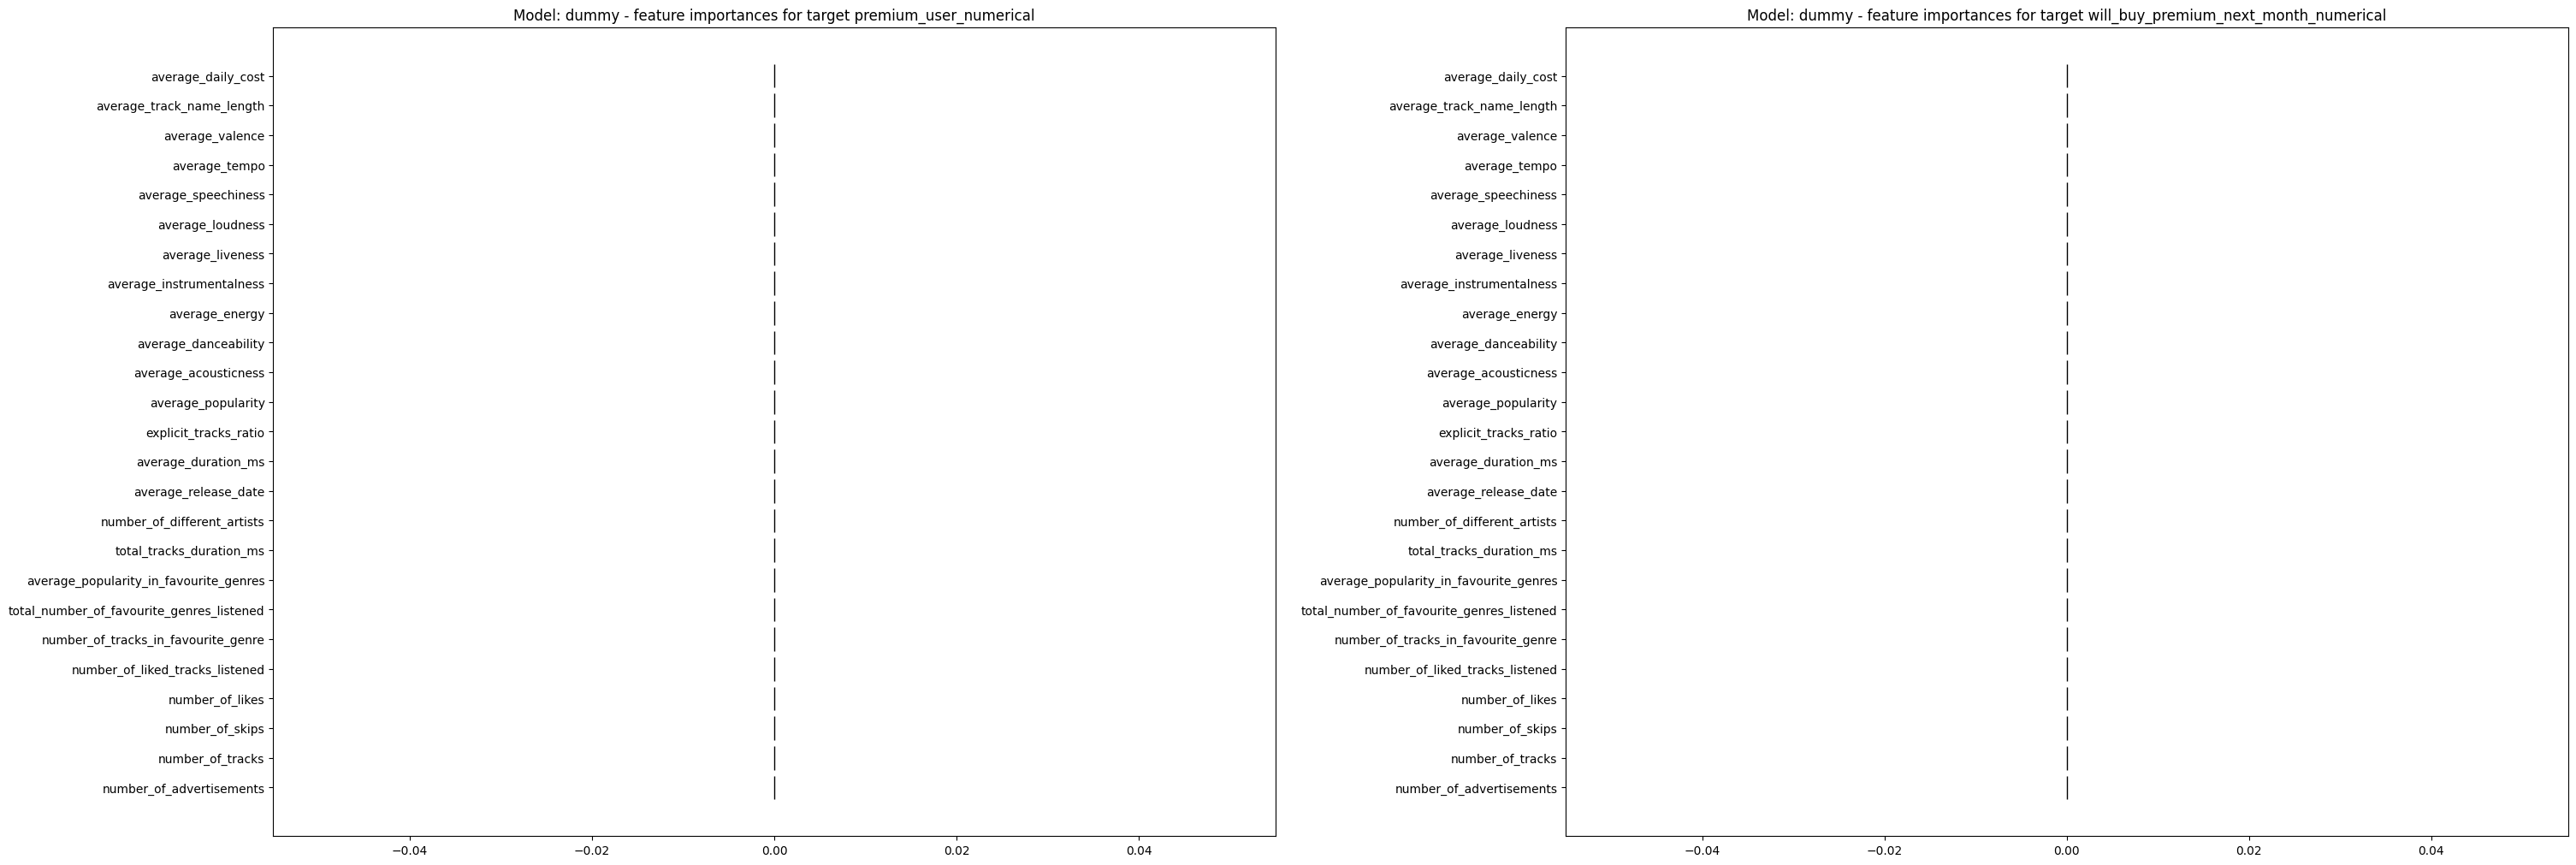

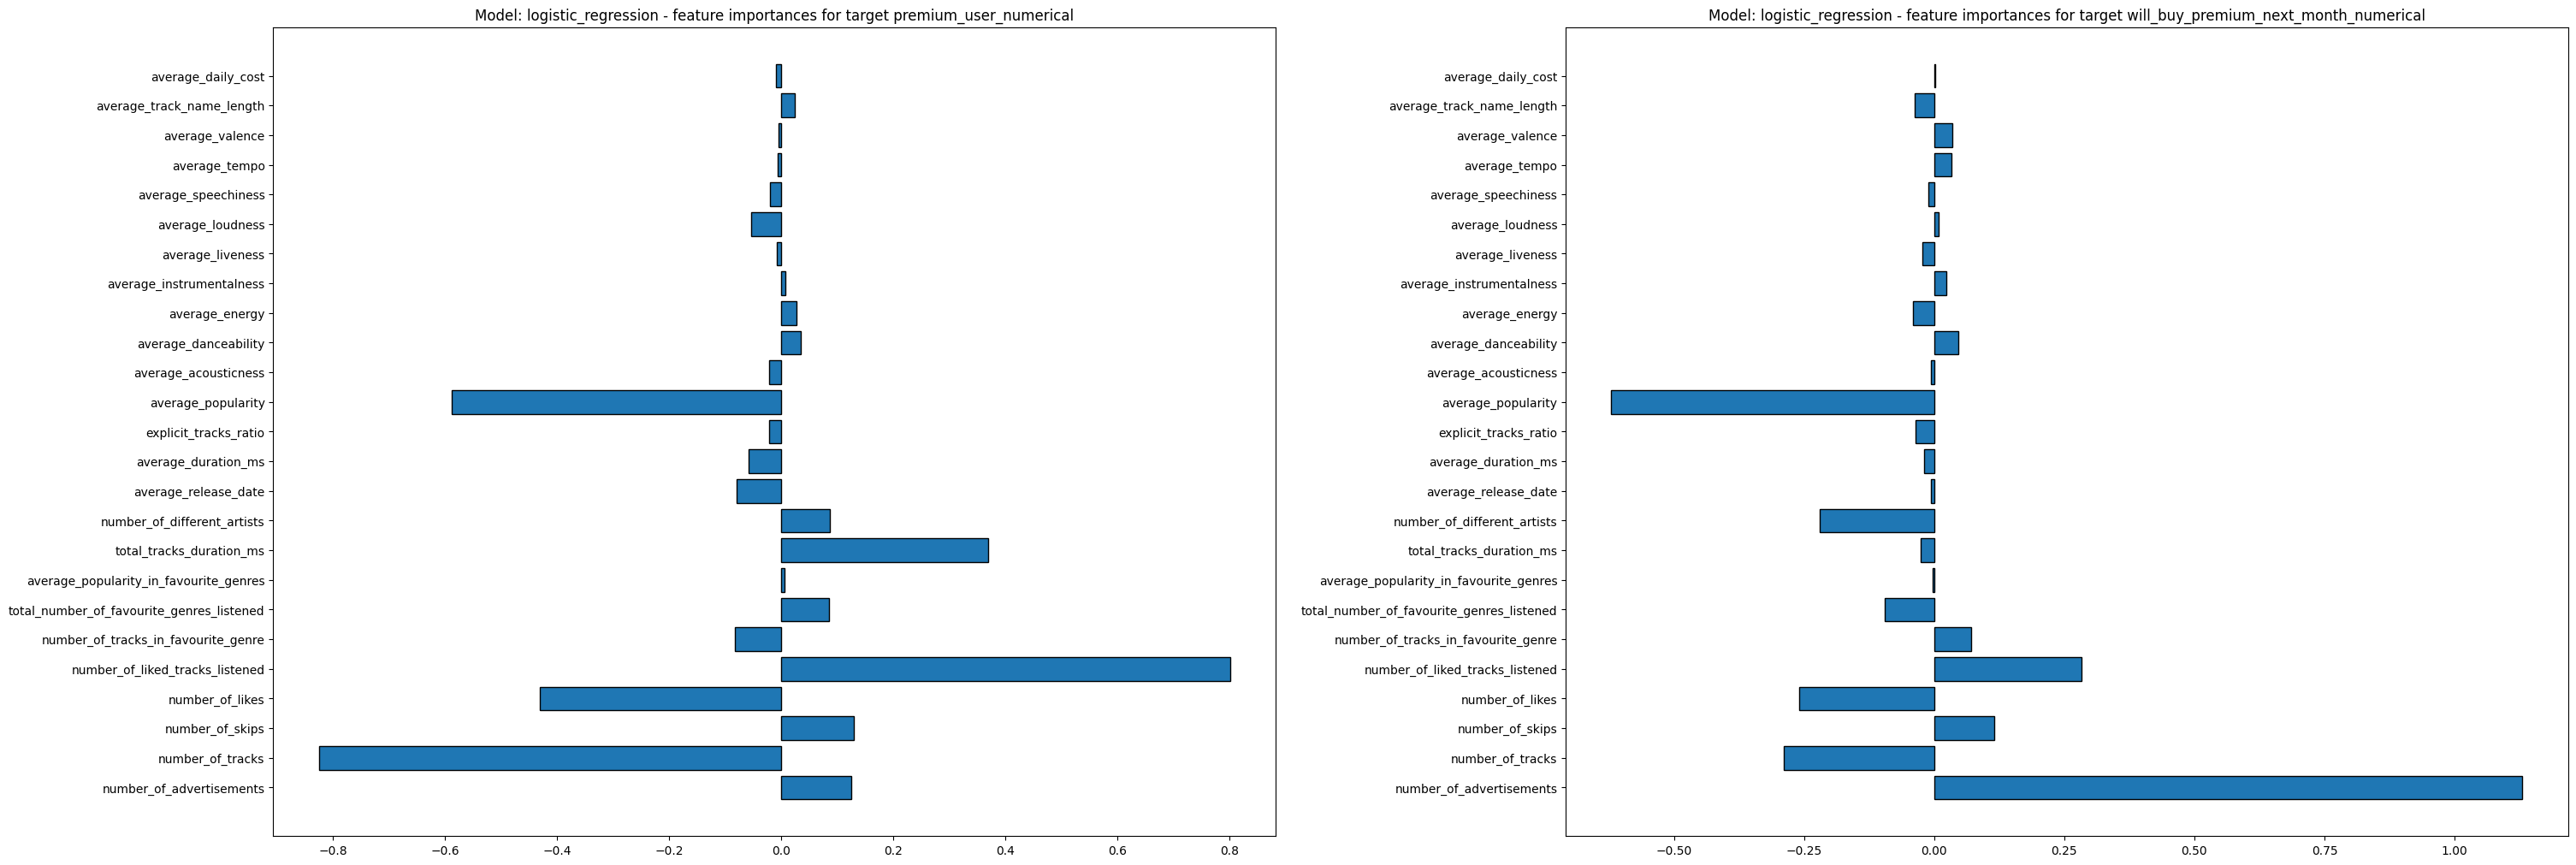

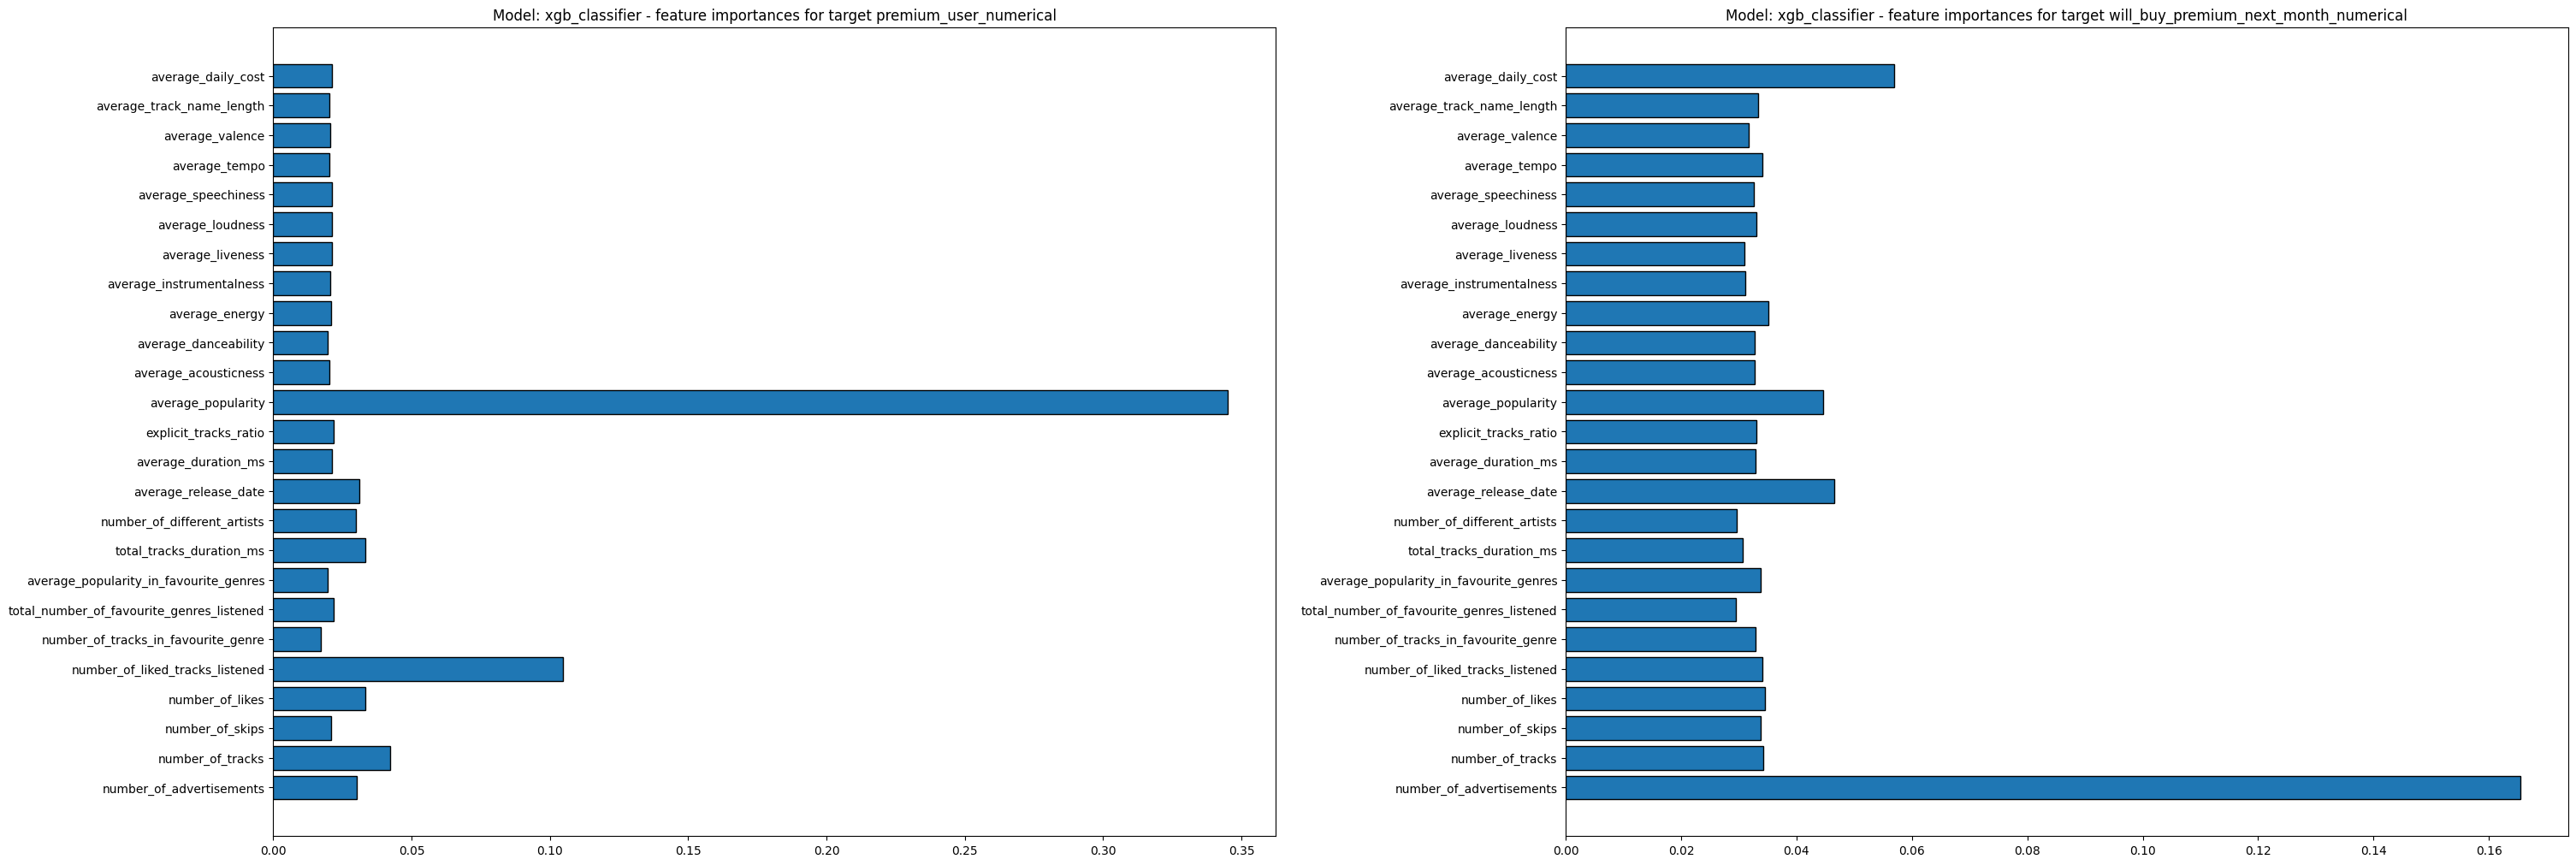

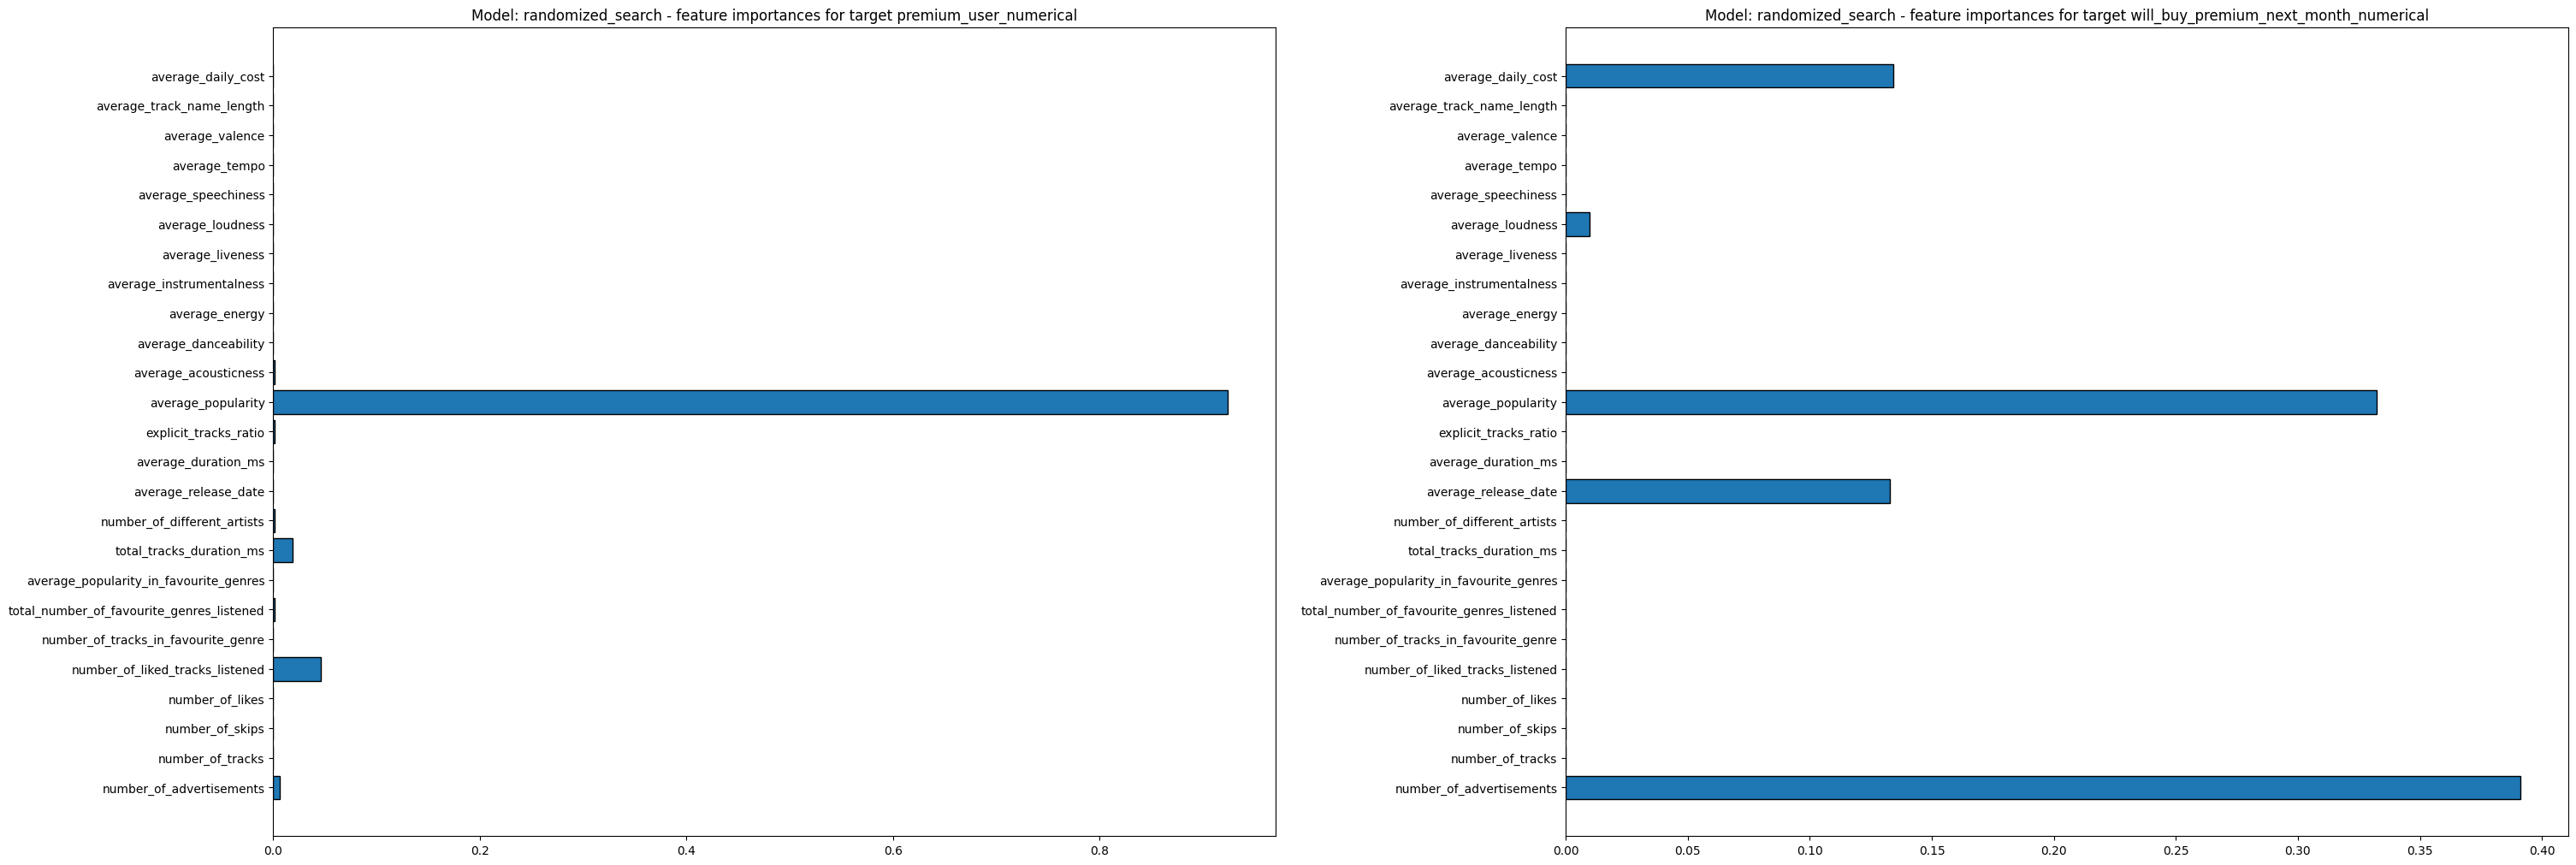

In [14]:
def retrieve_weights(model: Model) -> np.ndarray[np.float64]:
    if isinstance(model, LogisticRegression):
        return model.coef_[0]
    if isinstance(model, XGBClassifier):
        return model.feature_importances_
    return np.zeros(len(FEATURES))


for type in MODEL_TYPES:
    _, axs = plt.subplots(1, len(TARGETS), figsize=(
        30, 10), constrained_layout=True)
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        columns = FEATURES
        weights = retrieve_weights(model)
        axs[i].barh(y=columns, width=weights, edgecolor="black")
        axs[i].set_title(
            f"Model: {type} - feature importances for target {target}")
    plt.show()

In [15]:
# temp = 10
# plots = []
# MONTHS = 60
# subplots = [plt.subplots(4, MONTHS//4, figsize=(100, 40))
#             [1].flatten() for _ in TARGETS]
# plot_statistics = []
# for year, month in itertools.product(range(2019, 2023), range(1, 13)):
#     temp += 1
#     if temp % 10 != 0:
#         continue
#     data_train = data_frame.loc[
#         data_frame.apply(lambda x: x.year < year or (
#             x.month <= month and x.year == year), axis=1),
#         :
#     ]
#     if len(data_train) == 0:
#         continue
#     data_test = data_frame.loc[
#         data_frame.apply(lambda x: (x.month == month + 1 and x.year == year)
#                          or (x.year == year + 1 and x.month == 1), axis=1),
#         :
#     ]
#     x_train, y_train = data_train[FEATURES], data_train[TARGETS]
#     x_test, y_test = data_test[FEATURES], data_test[TARGETS]

#     plots.append(create_plot_from_model(x_train, y_train, x_test, y_test, [
#                  subplot[temp] for subplot in subplots], XGBClassifier, randomized_search_cv.best_params_))

# plt.show()

In [16]:
# TODO: F1 score, Precision, Recall figures

Eksperymenty A/B

In [18]:
X_train = pd.DataFrame(
    pipeline.fit_transform(TRAIN_DATA[FEATURES]),
    columns=FEATURES
)
Y_train = TRAIN_DATA[TARGETS]
for type in MODEL_TYPES:
    estimators = {}
    for target in TARGETS:
        y_train = Y_train[target]
        estimators[target] = MODEL_CONSTRUCTORS[type](X_train, y_train)
    model = IUMModel(pipeline, estimators)
    with open(f'models/{type}.pkl', 'wb') as f:
        pickle.dump(model, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END eta=0.006959804632076738, gamma=0.482426178996458, max_depth=3, n_estimators=18;, score=0.524 total time=  24.3s
[CV 3/5] END eta=0.006959804632076738, gamma=0.482426178996458, max_depth=3, n_estimators=18;, score=0.544 total time=  24.4s
[CV 4/5] END eta=0.006959804632076738, gamma=0.482426178996458, max_depth=3, n_estimators=18;, score=0.534 total time=  24.4s
[CV 2/5] END eta=0.006959804632076738, gamma=0.482426178996458, max_depth=3, n_estimators=18;, score=0.536 total time=  24.5s
[CV 5/5] END eta=0.006959804632076738, gamma=0.482426178996458, max_depth=3, n_estimators=18;, score=0.525 total time=  24.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END eta=0.059214887460176835, gamma=0.26061942581265773, max_depth=3, n_estimators=12;, score=0.238 total time=  19.1s
[CV 4/5] END eta=0.059214887460176835, gamma=0.26061942581265773, max_depth=3, n_estimators=12;, score=0.221 total time=  19

In [19]:
random_premutation = np.random.permutation(TRAIN_DATA.index)
size = len(random_premutation) // len(MODEL_TYPES)

REALITIES: Dict[str, pd.DataFrame] = {}

for i, type in enumerate(MODEL_TYPES):
    indices = random_premutation[i * size:(i + 1) * size]
    REALITIES[type] = TRAIN_DATA.loc[indices]

In [23]:
for type in MODEL_TYPES:
    display(REALITIES[type].head())

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
85879,7384,2022,12,0,0,0,2,6,0,1,...,0.697667,0.610000,0.025553,0.108233,-6.744667,0.117650,113.822333,0.519167,11.833333,0.019585
4612,4641,2022,12,0,0,0,11,26,8,7,...,0.467269,0.710577,0.105326,0.277654,-9.090962,0.054246,117.734269,0.530000,21.615385,0.014249
64430,2506,2020,7,1,0,0,6,34,1,4,...,0.651029,0.591824,0.000664,0.159003,-6.580676,0.082576,113.686412,0.450965,11.382353,0.022848
154209,4890,2020,11,0,0,0,8,36,2,9,...,0.639111,0.624278,0.040548,0.165750,-6.882778,0.097278,114.627417,0.495233,12.583333,0.023919
8495,12383,2021,8,0,0,0,8,18,9,9,...,0.459833,0.692667,0.068705,0.231333,-8.658000,0.055961,124.729056,0.481606,22.611111,0.011900


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
54702,15415,2022,11,0,0,0,6,18,6,4,...,0.509556,0.639833,0.124883,0.335200,-9.819722,0.054033,115.979722,0.595667,27.944444,0.014795
169213,6023,2020,3,0,0,0,12,31,13,11,...,0.499645,0.646648,0.065959,0.216610,-9.656258,0.085855,129.575677,0.511181,22.032258,0.011948
116780,15232,2021,8,0,0,0,6,23,3,3,...,0.696261,0.544217,0.018563,0.106626,-7.409000,0.085204,110.539739,0.562957,12.304348,0.020981
45139,2511,2020,8,1,0,0,12,31,4,11,...,0.657097,0.625129,0.045955,0.159084,-6.006032,0.076752,113.049258,0.463119,14.032258,0.024301
22915,18554,2020,12,1,0,0,5,17,8,7,...,0.496588,0.623765,0.193011,0.152682,-9.683118,0.040935,129.841176,0.514641,22.117647,0.013916


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
99231,8062,2020,10,0,0,0,10,26,1,3,...,0.609731,0.640269,0.026306,0.161708,-6.141962,0.099365,123.476269,0.479077,12.461538,0.025231
139405,12046,2021,8,1,0,0,7,17,9,3,...,0.456941,0.626000,0.099794,0.257841,-9.977706,0.050382,136.903000,0.554176,26.235294,0.013168
37246,18678,2022,10,0,0,0,7,29,1,6,...,0.680414,0.553207,0.028077,0.146938,-6.991069,0.108593,112.112931,0.479586,10.965517,0.023925
19531,18230,2021,7,1,0,0,4,8,4,2,...,0.433375,0.639687,0.293603,0.387688,-10.791875,0.066075,114.297375,0.451500,31.125000,0.015075
47810,4734,2022,8,0,0,0,7,17,1,8,...,0.687765,0.641412,0.040198,0.156253,-5.942882,0.119018,112.051765,0.524765,12.705882,0.021630


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
52403,18140,2020,6,0,0,0,0,26,3,12,...,0.679577,0.625154,0.001123,0.153800,-6.303923,0.106715,115.920154,0.537554,11.346154,0.026150
57122,7456,2021,8,0,0,0,7,20,2,2,...,0.644500,0.541850,0.026806,0.135530,-7.659300,0.089820,109.573350,0.419000,12.300000,0.022539
89993,10192,2022,2,0,0,0,4,17,1,4,...,0.719529,0.555647,0.039244,0.155871,-7.308647,0.086418,116.546471,0.511082,12.588235,0.025826
98236,6191,2020,11,0,0,0,10,22,8,4,...,0.465000,0.615055,0.206660,0.200500,-10.627273,0.049436,122.790091,0.510318,21.636364,0.013908
117637,6740,2021,4,1,0,0,11,21,15,8,...,0.474857,0.669519,0.210788,0.209205,-9.718905,0.074605,124.116810,0.421381,24.571429,0.015193


In [42]:
result = {
    type: {
        target: pd.DataFrame({
            "user_id": [],
            "year": [],
            "month": [],
            "guess": [],
            "ground_truth": [],
            "model": []
        })
        for target in TARGETS
    }
    for type in MODEL_TYPES
}

for type in MODEL_TYPES:
    url = f'http://127.0.0.1:5000/predict/{type}'
    for i in range(0, len(TEST_DATA)):
        row = TEST_DATA.iloc[i].to_dict()
        response = requests.post(url, json=row).json()
        for target in TARGETS:
            current = pd.DataFrame({
                "user_id": [row['user_id']],
                "year": [row['year']],
                "month": [row['month']],
                "guess": [1 if response[target] else 0],
                "ground_truth": [row[target]],
                "model": [type]}
            )
            result[type][target] = pd.concat(
                [result[type][target], current], ignore_index=True
            )

In [50]:
for type in MODEL_TYPES:
    print(type.upper())
    for target in TARGETS:
        print(target)
        print()
        print(result[type][target].guess.value_counts())
        print()
        print(result[type][target].ground_truth.value_counts())
        f1_score_value = f1_score(
            result[type][target].ground_truth, result[type][target].guess
        )
        print()
        print('f1 score = ', f1_score_value)
        print()

DUMMY
premium_user_numerical



0.0    9972
Name: guess, dtype: int64


0.0    9707
1.0     265
Name: ground_truth, dtype: int64

f1 score =  0.0

will_buy_premium_next_month_numerical



0.0    9972
Name: guess, dtype: int64


0.0    9808
1.0     164
Name: ground_truth, dtype: int64

f1 score =  0.0

LOGISTIC_REGRESSION
premium_user_numerical



0.0    9809
1.0     163
Name: guess, dtype: int64


0.0    9707
1.0     265
Name: ground_truth, dtype: int64

f1 score =  0.09345794392523364

will_buy_premium_next_month_numerical



0.0    9972
Name: guess, dtype: int64


0.0    9808
1.0     164
Name: ground_truth, dtype: int64

f1 score =  0.0

XGB_CLASSIFIER
premium_user_numerical



0.0    9600
1.0     372
Name: guess, dtype: int64


0.0    9707
1.0     265
Name: ground_truth, dtype: int64

f1 score =  0.09419152276295131

will_buy_premium_next_month_numerical



0.0    9967
1.0       5
Name: guess, dtype: int64


0.0    9808
1.0     164
Name: ground_truth, dtype: int64

f1 score =  0.03550295857988166

RANDOMIZED_SEARCH
premium_user_numerical



0.0    6859
1.0    3113
Name: guess, dtype: int64


0.0    9707
1.0     265
Name: ground_truth, dtype: int64

f1 score =  0.09117821195973948

will_buy_premium_next_month_numerical



0.0    9760
1.0     212
Name: guess, dtype: int64


0.0    9808
1.0     164
Name: ground_truth, dtype: int64

f1 score =  0.18617021276595744



In [46]:
for type in MODEL_TYPES:
    for target in TARGETS:
        result[type][target].to_csv(f'ab_experiment/{type}-{target}.csv')

In [44]:
# np.random.seed(1234)

# print(f"{BUCKETS_CNT=}, {T_ALPHA=}")
# data = load_data()
# buckets_indices = get_buckets_indices(data.user_id.values)
# xgb_f1_score, logreg_f1_score = get_xgb_logreg_f1_scores(data, buckets_indices)
# print(f"{np.mean(xgb_f1_score)=}, {np.mean(logreg_f1_score)=}")
# s_p = get_s_p(xgb_f1_score, logreg_f1_score)
# t = get_t(xgb_f1_score, logreg_f1_score, s_p)
# print(f"{s_p=}, {t=}")
# if is_xgb_better(t):
#     print("XGBClassifier is better than LogisticRegression")
# else:
#     print("We can't say that XGBClassifier is better than LogisticRegression")